# Сегментация радионуклидных изображений печени

### Импорты

In [1]:
import os
import random
from os.path import join as pjoin
import albumentations
import numpy as np
import torch
from PIL import Image
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2
from dataset import CustomDataset
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from train import (
    CheckpointSaver,
    load_checkpoint,
    train,
)
from unet import UNet
from metric import MeanIoU
from loss import DiceLoss

### Установка начального значения генераторов случайных чисел

In [2]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)
seed_everything(42, torch_deterministic=False)

### Преобразования изображений (аугментации)

In [3]:
IMAGE_SIZE = 256
transforms = albumentations.Compose(
    [
        albumentations.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
        ToTensorV2(),
    ]
)

### Примеры радионуклидных ихображений печени и соответсвующих им масок

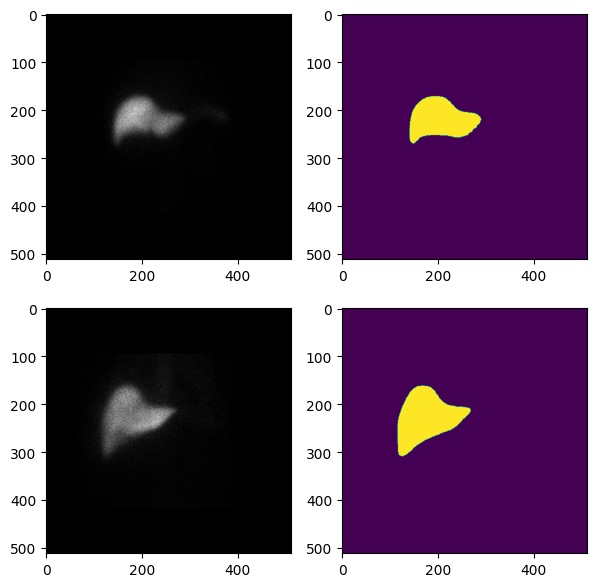

In [4]:
image1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (2).png")
mask1 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (2).png")
image2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/images/image (3).png")
mask2 = Image.open("C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data/masks/mask_image (3).png")
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ax[0, 0].imshow(image1)
ax[0, 1].imshow(mask1)
ax[1, 0].imshow(image2)
ax[1, 1].imshow(mask2)

### Разделение датасета на тренировочный, валидационный и тестовый (70/20/10)

In [5]:
full_dataset = CustomDataset(root_dir="C:/Users/dev1ce/Documents/GitHub/segmentation/segmentation/data",transforms = transforms)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])
print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))


Количество изображений в полном датасете: 253
Количество изображений в тренировочном датасете: 177
Количество изображений в валидационном датасете: 50
Количество изображений в тестовом датасете: 26


### Настройка гиперпараметров

In [6]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_WORKERS = 2
EPOCH_NUM = 20
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

### Создание модели

In [7]:
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)

model = UNet(in_channels=3, out_channels=1)

loss_fn = DiceLoss()
metric_fn = MeanIoU()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=5, gamma=0.8
) #уменьшение скорости обучения

### Подготовка модели, данных и оптимизатора к обучению

In [8]:
accelerator = Accelerator(cpu=False, mixed_precision="fp16")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="DICE",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

### Обучение модели

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

------------------------------
Epoch 0/20


Training:   0%|          | 0/45 [00:00<?, ?it/s]

### Загрузим и протестируем обученную модель

In [ ]:
model = UNet(in_channels=3, out_channels=1)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval()

In [ ]:
sample_idx = 1
image, target = test_dataset[sample_idx]
thresold = 0.8
preds = F.sigmoid(model(image.unsqueeze(0).to(DEVICE))).squeeze(0)
binary_preds = (preds > thresold)
fig, ax = plt.subplots(1, 3, figsize=(9, 18))
ax[0].imshow(image.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[0].set_title("Original Image") 
ax[1].imshow(target.numpy().transpose(1, 2, 0).astype(np.uint8))
ax[1].set_title("Target Mask")
ax[2].imshow(binary_preds.cpu().numpy()[0])
ax[2].set_title("Predicted Mask") 